<a href="https://colab.research.google.com/github/beaterblank/JPEG-ENCODER/blob/main/JPEG_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!rm * -rf
!wget https://raw.githubusercontent.com/beaterblank/MyServer/main/img.zip 
!unzip img.zip
!rm img.zip
!pip install rawpy

--2022-07-28 09:11:15--  https://raw.githubusercontent.com/beaterblank/MyServer/main/img.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15231622 (15M) [application/zip]
Saving to: ‘img.zip’

img.zip             100%[===================>]  14.53M  --.-KB/s    in 0.1s    

2022-07-28 09:11:16 (131 MB/s) - ‘img.zip’ saved [15231622/15231622]

Archive:  img.zip
  inflating: img.dng                 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import math
from scipy.fft import dctn, idctn
mpl.rcParams['figure.figsize'] = (20,16)
mpl.rcParams['axes.grid'] = False
np.set_printoptions(suppress=True)

# ENCODE

## Read the Image

In [ ]:
def getRGB(path):
  with rawpy.imread(path) as raw:
      rgb = raw.postprocess()
  return rgb

In [ ]:
rgb = getRGB('img.dng')
rgb.shape

(3456, 4608, 3)

## RGB to YCbCr

In [ ]:
def RGBtoYCbCr(img):
  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  newImg = np.zeros(img.shape)

  Y  =  0.299*R+0.587*G+0.114*B
  Cb = -0.1687*R-0.3313*G+0.5*B+128
  Cr =  0.5*R-0.4187*G-0.0813*B+128
  
  return (Y,Cb,Cr)

In [ ]:
(Y,Cb,Cr) = RGBtoYCbCr(rgb)

## Padding

In [ ]:
def Pad(Channel,by):
  (x,y) = Channel.shape
  nx = by*math.ceil(x/by)
  ny = by*math.ceil(y/by)
  ret = np.zeros((nx,ny))
  ret[:x,:y] = Channel[:,:]
  return ret

## Splitting

In [ ]:
def split(Channel,size):
  pCh = Pad(Channel,size)
  blocks = []
  x,y = pCh.shape
  for i in range(0,x,size):
    for j in range(0,y,size):
      blocks.append(pCh[i:i+size,j:j+size])
  return np.array(blocks).reshape(len(range(0,x,size)),len(range(0,y,size)),size,size)

## DownSample

In [ ]:
def DownSample(Channel,size):
  if(size == 1):
    return Channel
  blocks = split(Channel,size)
  x,y,s,_ = blocks.shape
  ret = np.zeros((x,y))
  for i in range(x):
    for j in range(y):
      ret[i,j] = blocks[i,j].sum()/(s*s)
  return ret

In [ ]:
Y_d = DownSample(Y,1)
Cb_d = DownSample(Cb,4)
Cr_d = DownSample(Cr,4)

## DCT

In [ ]:
def dctTables(Channel):
  blocks = split(Channel,8)
  (x,y,s,_) = blocks.shape
  ret = np.zeros((x,y,s,s))
  for i in range(x):
    for j in range(y):
      ret[i,j] = dctn(blocks[i,j]) 
  return ret

In [ ]:
Y_dct = dctTables(Y_d)
Cb_dct = dctTables(Cb_d)
Cr_dct = dctTables(Cr_d)

## Quantization

In [ ]:
luminenceTable =np.array([
[4,3,4,4,4,6,11,15],
[3,3,3,4,5,8,14,19],
[3,4,4,5,8,12,16,20],
[4,5,6,7,12,14,18,20],
[6,6,9,11,14,17,21,23],
[9,12,12,18,23,22,25,21],
[11,13,15,17,21,23,25,21],
[13,12,12,13,16,19,21,21]
])
ChrominanceTable = np.array([
[4,4,6,10,21,21,21,21],
[4,5,6,21,21,21,21,21],
[6,6,12,21,21,21,21,21],
[10,14,21,21,21,21,21,21],
[21,21,21,21,21,21,21,21],
[21,21,21,21,21,21,21,21],
[21,21,21,21,21,21,21,21],
[21,21,21,21,21,21,21,21]                      
])

In [ ]:
def Quantize(dctBlocks,table):
  (x,y,s,_) = dctBlocks.shape
  ret = np.zeros((x,y,s,s))
  for i in range(x):
    for j in range(y):
      ret[i,j] = np.floor_divide(dctBlocks[i,j],table)
  return ret

In [ ]:
Y_quant = Quantize(Y_dct,luminenceTable)
Cb_quant = Quantize(Cb_dct,ChrominanceTable)
Cr_quant = Quantize(Cr_dct,ChrominanceTable)

## ZigZagCoding

In [ ]:
def zigzag(block):
  s = block.shape
  rows = s[0]
  columns = s[1]
  solution=[[] for i in range(rows+columns-1)]
  for i in range(rows):
      for j in range(columns):
          sum=i+j
          if(sum%2 ==0):
              solution[sum].insert(0,block[i][j])
          else:
              solution[sum].append(block[i][j])
  ret = []
  for item in solution:
    for subitem in item:
      ret.append(subitem)
  return ret

def dezigzag(code):
  size = int(np.sqrt(len(code)))
  arr = np.array([0,0]*size*size).reshape((size,size,2))
  out = np.zeros((size,size))
  for i in range(size):
    for j in range(size):
      arr[i,j,0] = i
      arr[i,j,1] = j
  temp = np.array(zigzag(arr)).tolist()
  for i,j in zip(code,temp):
    out[j[0],j[1]] = i
  return out

In [ ]:
block = np.array([[1, 2, 3], [4, 5, 6],[7, 8, 9]])

dezigzag(zigzag(block))

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

## Write

# Decode

## Dequantize

In [ ]:
def DeQuantize(dctBlocks,table):
  (x,y,s,_) = dctBlocks.shape
  ret = np.zeros((x,y,s,s))
  for i in range(x):
    for j in range(y):
      ret[i,j] = dctBlocks[i,j]*table
  return ret

In [ ]:
Y_dquant = DeQuantize(Y_quant,luminenceTable)
Cb_dquant = DeQuantize(Cb_quant,ChrominanceTable)
Cr_dquant = DeQuantize(Cr_quant,ChrominanceTable)

## Inverse DCT

In [ ]:
def cTables(quantTables):
  (x,y,s,_) = quantTables.shape
  ret = np.zeros((x,y,s,s))
  for i in range(x):
    for j in range(y):
      ret[i,j] = idctn(quantTables[i,j]) 
  return ret

In [ ]:
Y_decoded = cTables(Y_dquant)
Cb_decoded = cTables(Cb_dquant)
Cr_decoded = cTables(Cr_dquant)

## Recombine

In [ ]:
def Combine(blocks):
  (x,y,s,_) = blocks.shape
  out = np.zeros((x*s,y*s))
  for i in range(0,x):
    for j in range(0,y):
      out[i*s:i*s+s,j*s:j*s+s] = blocks[i,j]
  return out

## Output

In [ ]:
Y_out = Combine(Y_decoded)
Cb_out = Combine(Cb_decoded)
Cr_out = Combine(Cr_decoded)

In [ ]:
def Upsample(Channel,size):
  if(size == 1):
    return Channel
  x,y = Channel.shape 
  _x = x*size
  _y = y*size
  ret = np.zeros((_x,_y))
  for i in range(x):
    for j in range(y):
      ret[i*size:i*size+size,j*size:j*size+size] = np.ones((size,size))*Channel[i,j]
  return ret

In [ ]:
Y_final  = Upsample(Y_out,1)
Cb_final = Upsample(Cb_out,4)
Cr_final = Upsample(Cr_out,4)

## YCbCr to RGB



In [ ]:
def YCbCrToRGB(Y,Cb,Cr):
    x,y = Y.shape
    
    Cr = Cr-128;
    Cb = Cb-128;

    r = Y + 113 * Cr / 64 ;
    g = Y - (11 * Cb + 23 * Cr) / 32 ;
    b = Y + 113 * Cb / 64 ;

    rgb = np.zeros((x,y,3))
    rgb[:,:,0] = r
    rgb[:,:,1] = g
    rgb[:,:,2] = b

    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)

    return np.uint8(rgb)

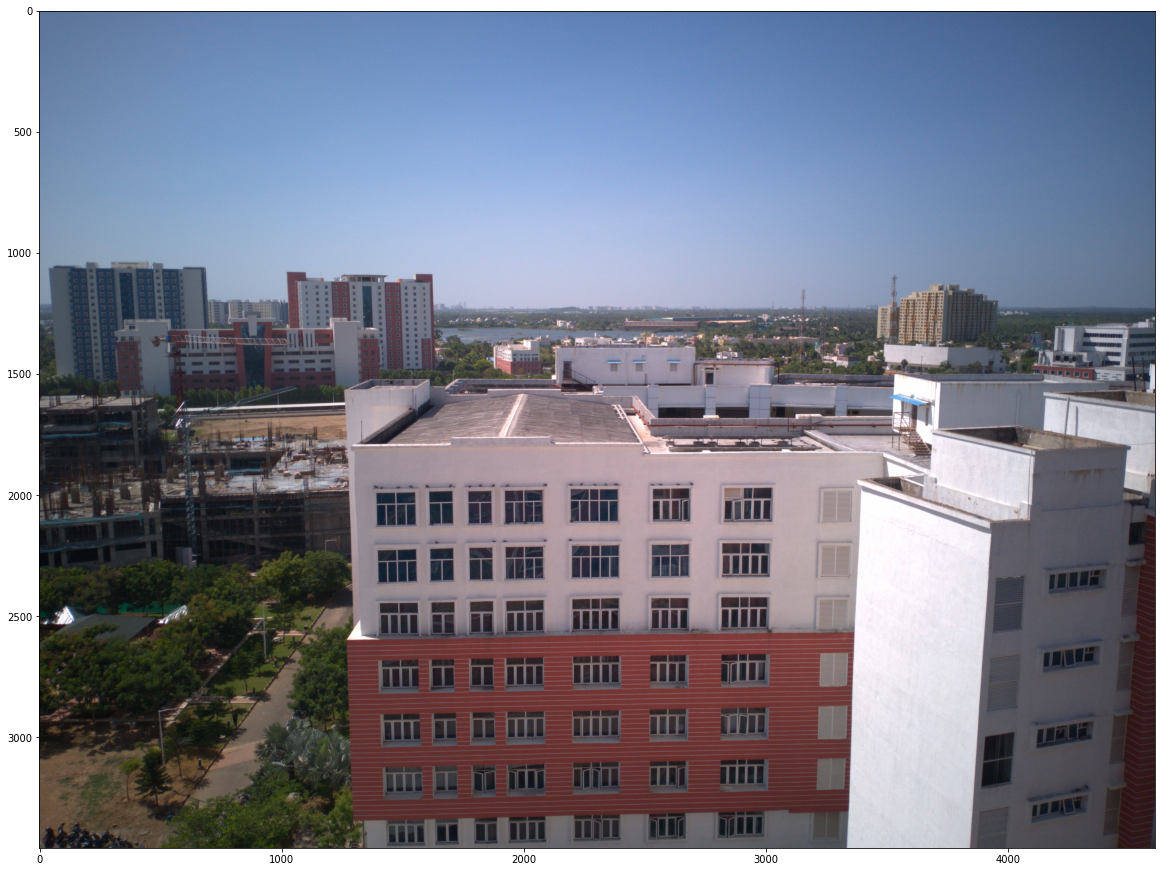

In [ ]:
plt.imshow(YCbCrToRGB(Y_final,Cb_final,Cr_final))